# Network summary

In this notebook we will get general info about ego graph.

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import scipy.stats as sps
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tqdm.notebook import tqdm

sns.set(font_scale=1.3)

In [2]:
DATA_PREFIX = os.path.join(os.pardir, 'data')
FIGURES_PREFIX = os.path.join(os.pardir, 'figures')

Graph is obtained by vk.api method `friends.get`. Attributes:
1. First name
2. Last name
3. Sex
4. City
5. University (last)

Graph is undirected and unweighted.

In [3]:
g = nx.read_gml(os.path.join(DATA_PREFIX, 'graph.gml'))

### General info

Let's look at the main characteristics

In [4]:
print(f'Number of nodes: {g.number_of_nodes()}')
print(f'Number of edges: {g.number_of_edges()}')
print(f'Number of connected components: {nx.number_connected_components(g)}')

Number of nodes: 133
Number of edges: 1465
Number of connected components: 5


Graph is not connected, so let's look at it carefully.

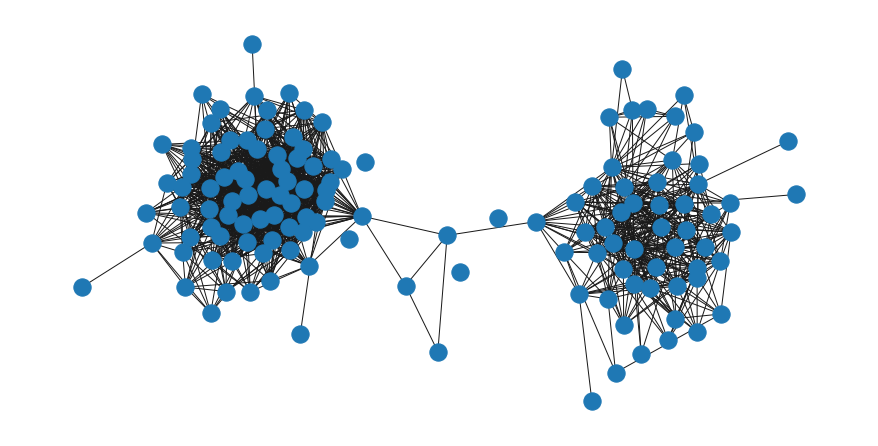

In [5]:
plt.figure(figsize=(12, 6))
nx.draw_kamada_kawai(g)
plt.show()

We immediately can see here a two big subcomponents and a few null-degree nodes.

To analyse radius and diamter we can get rid of them and consider only the biggest connected component.

In [6]:
connected_components = list(nx.connected_components(g))
connected_components.sort(key=lambda x: len(x), reverse=True)
biggest_cc = connected_components[0]
print(f'Size of the biggest connected component: {len(biggest_cc)}')
g_sub = g.subgraph(biggest_cc)

Size of the biggest connected component: 129


In [7]:
print(f'Diameter: {nx.diameter(g_sub)}')
print(f'Radius: {nx.radius(g_sub)}')

Diameter: 8
Radius: 4


### Clustering coefficients

Let's look at clustering coefficients.

In [8]:
clustering_locals = list(nx.clustering(g).values())
print(f'Clustering average locals: {np.mean(clustering_locals):.3f}')

Clustering average locals: 0.577


Clustering distribution:

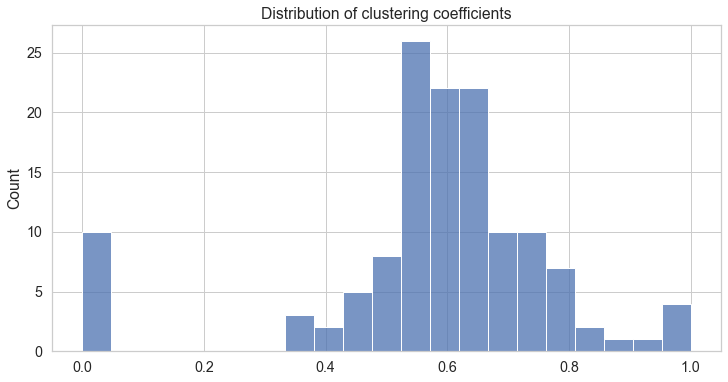

In [9]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(12, 6))
    sns.histplot(clustering_locals)
    plt.title('Distribution of clustering coefficients')
    plt.savefig(os.path.join(FIGURES_PREFIX, 'clustering distribution.png'), 
                bbox_inches='tight', dpi=300)
    plt.show()

### Average path lengths

Let's look at average path lengths.

In [10]:
average_length = nx.average_shortest_path_length(g_sub)
print(f'Average path length: {average_length:.3f}')
path_lengths = list(nx.shortest_path_length(g_sub))

Average path length: 3.499


In [11]:
path_lengths = [value for node in path_lengths for value in node[1].values()]

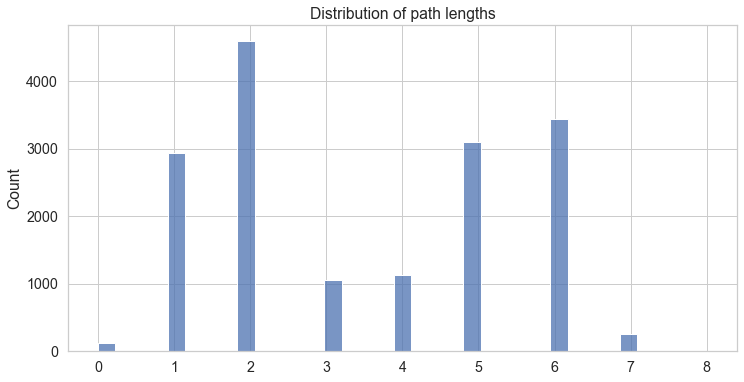

In [12]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(12, 6))
    sns.histplot(path_lengths)
    plt.title('Distribution of path lengths')
    plt.savefig(os.path.join(FIGURES_PREFIX, 'path length distribution.png'), 
                bbox_inches='tight', dpi=300)
    plt.show()

### Degree distribution

Let's look at distributions of degree.

In [13]:
degrees = np.array(list(dict(g.degree()).values()))
pd.Series(degrees).describe()

count    133.000000
mean      22.030075
std       14.189700
min        0.000000
25%       11.000000
50%       21.000000
75%       32.000000
max       53.000000
dtype: float64

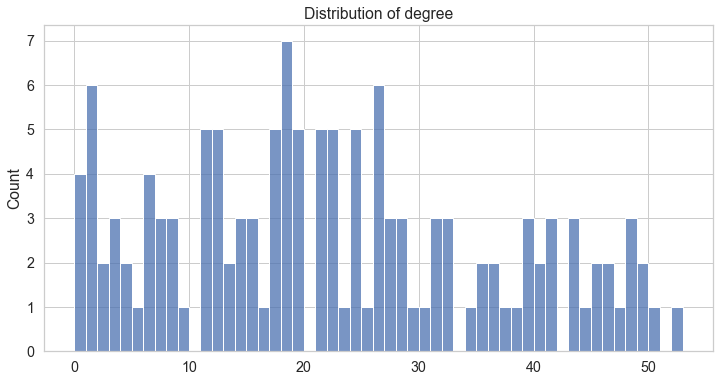

In [14]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(12, 6))
    sns.histplot(degrees, bins=np.max(degrees))
    plt.title('Distribution of degree')
    plt.savefig(os.path.join(FIGURES_PREFIX, 'degree distribution.png'), 
                bbox_inches='tight', dpi=300)
    plt.show()

We can see a very long tail here. Let's try to fit a power law.

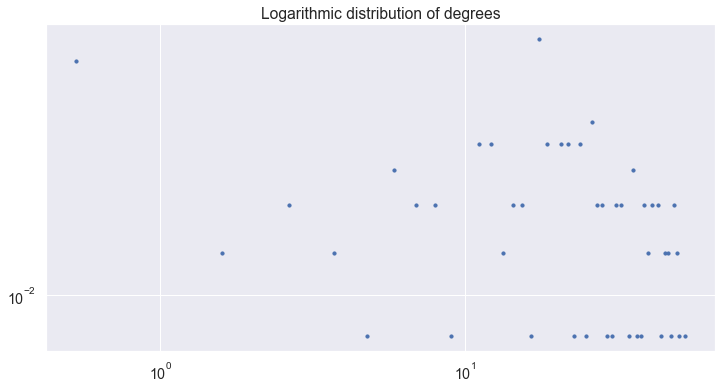

In [15]:
plt.figure(figsize=(12, 6))
hist, bin_edges = np.histogram(degrees, bins=50, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.scatter(bin_centers, hist, s=10)
plt.title('Logarithmic distribution of degrees')
plt.xscale('log')
plt.yscale('log')
plt.savefig(os.path.join(FIGURES_PREFIX, 'degree lograrithmic distribution.png'), 
            bbox_inches='tight', dpi=300)
plt.show()

It may be difficult to properly fit a power law on such a small amount of data.

In [16]:
def power_law_cdf(x, alpha=3.5, x_min=1):
    C = (alpha - 1) / x_min ** (1 - alpha)
    return 1 - C * x ** (1 - alpha) / (alpha - 1)

def power_law_pdf(x, alpha=3.5, x_min=1):
    C = (alpha - 1) / x_min ** (1 - alpha)
    return C * x ** (-alpha)

def mle_power_law_params(degree_sequence):
    from scipy.stats import kstest
    best_alpha, best_x_min = None, None
    min_ks_dist = np.inf
    for x_min in np.arange(degree_sequence.min(), degree_sequence.max()):
        x = degree_sequence[degree_sequence >= x_min]
        alpha = 1 + len(x) / np.log(x / x_min).sum()
        ks_dist = kstest(x, power_law_cdf, args=(alpha, x_min)).statistic
        if ks_dist < min_ks_dist:
            min_ks_dist, best_alpha, best_x_min = ks_dist, alpha, x_min
    return best_alpha, best_x_min

In [17]:
alpha, x_min = mle_power_law_params(degrees)
print(f'alpha: {alpha:.3f}')
print(f'x_min: {x_min}')

alpha: 3.359
x_min: 21


/tmp/ipykernel_103890/238149559.py:15: RuntimeWarning: divide by zero encountered in true_divide
  alpha = 1 + len(x) / np.log(x / x_min).sum()
/tmp/ipykernel_103890/238149559.py:15: RuntimeWarning: invalid value encountered in true_divide
  alpha = 1 + len(x) / np.log(x / x_min).sum()


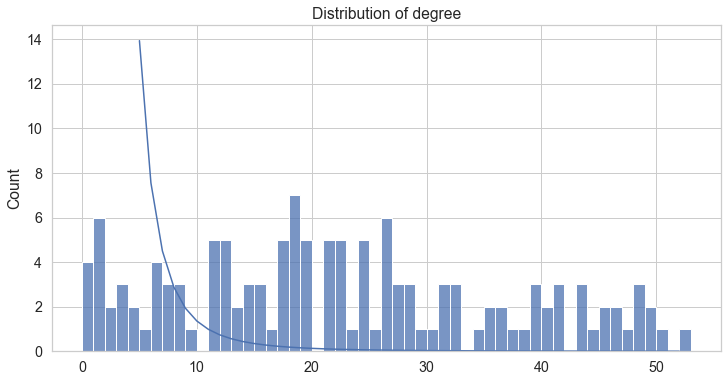

In [18]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(12, 6))
    grid = np.arange(5, np.max(degrees))
    plt.plot(grid, power_law_pdf(grid, alpha, x_min))
    sns.histplot(degrees, bins=np.max(degrees))
    plt.title('Distribution of degree')
    plt.savefig(os.path.join(FIGURES_PREFIX, 'degree distribution.png'), 
                bbox_inches='tight', dpi=300)
    plt.show()

The result looks bad.

### Network layout

Let's try to draw network nicely.

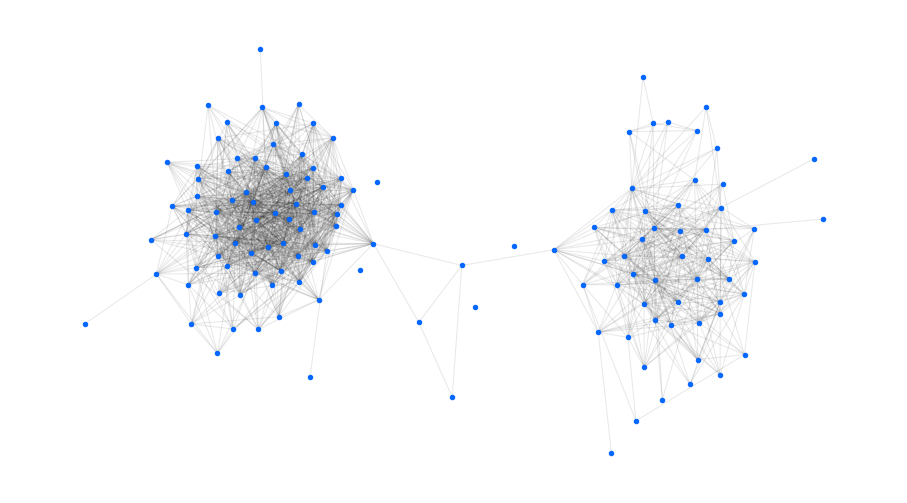

In [19]:
plt.figure(figsize=(16, 9))
layout = nx.kamada_kawai_layout(g)
nx.draw_networkx_nodes(g, pos=layout, node_size=20, node_color='#0066FF')
nx.draw_networkx_edges(g, pos=layout, alpha=0.1)
plt.axis('off')
plt.savefig(os.path.join(FIGURES_PREFIX, 'plain layout.png'), 
            bbox_inches='tight', dpi=300)
plt.show()

Looks interesting to analyse in the next notebook.